# Tic-Tac-Toe Agent
​
In this notebook, I have built an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. it's strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
- Defining epsilon-greedy strategy
- Tracking state-action pairs for convergence
- Define hyperparameters for the Q-learning algorithm
- Generating episode and applying Q-update equation
- Checking convergence in Q-values

## 1. Importing libraries
Writing the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env1 import TicTacToe   # import class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):  
    x = env.action_space(state)[0]    
    valid_Actions = [i for i in x] 
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values (for new state) to the Q-dictionary

def add_to_dict(state):
    state1 = Q_state(state)
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

## 2. Epsilon-greedy strategy

In [10]:
# Defining epsilon-greedy policy.

def epsilon_greedy(state, ep):
    epsilon = 0.8*np.power(1.000001,-ep)          
    z = np.random.random()        
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        action = random.choice(valid_actions(state))    #Exploration: randomly choosing and action    
    return action

## 3. Tracking the state-action pairs for checking convergence

In [11]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence check)

Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [12]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                ('x-3-x-x-2-x-x-x-x',(7,5)),('3-5-x-x-x-x-4-6-x',(2,7)),
               ('x-x-9-x-x-4-x-x-x',(6,5))]
    
    for samp in sample_q:
        state_tra = samp[0]
        action_tra = samp[1]
        States_track[state_tra][action_tra] = []


# saving the tracked state-action pair values
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict.keys() and action in Q_dict[state].keys():
                States_track[state][action].append(Q_dict[state][action])

In [13]:
#Defining a function to save the dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## 4. Q-update loop 

In [14]:
# Defining hyperparameters

EPISODES=10000000
GAMMA = 0.5
LR = 0.5

threshold = 2000      
policy_threshold = 30000

In [15]:
start_time = time.time()

reward_cum_ep = []
for episode in range(EPISODES):
    ##### Start writing your code from the next line

    env = TicTacToe()
    current_state = env.state    
    add_to_dict(current_state)   

    time_step = 0

    curr_action = random.choice(valid_actions(current_state))
        
    game_pos = False   #game_pos = False meaning game is not over yet
    
    cum_reward = 0   #tracking the total cumulative reward in an episode
    
    while game_pos == False:    # one episode will run only for a few steps and not infinitely
        
        next_state, reward, game_pos = env.step(current_state, curr_action)
        add_to_dict(next_state)
        
        cum_reward += reward      # accumulating the reward for current episode
            
        # UPDATE RULE
        if  game_pos == False:          #apply update only till the game is ON
            max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[Q_state(current_state)][curr_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next]))) - Q_dict[Q_state(current_state)][curr_action])     
            current_state = next_state       
            curr_action = epsilon_greedy(current_state, episode)   # exploring or exploiting action for the next state 
        else:                        # game is OFF now so next state is terminal state, henc no further action possible from that state
            Q_dict[Q_state(current_state)][curr_action] += LR * (reward - Q_dict[Q_state(current_state)][curr_action]) 
            current_state = next_state 

        time_step += 1   # to track the no. of steps in an episode
        
    #TRACKING REWARDS
    reward_cum_ep.append(cum_reward)     # appending the cum_reward for different episodes

    
     #TRACKING Q-VALUES
    if (episode == threshold-1 ):        #at the 1999th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')    
            
        
elapsed_time = time.time() - start_time
print('Total Episode run = ', episode)
print('Total time taken = ', elapsed_time)
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

Total Episode run =  9999999
Total time taken =  9493.931564092636


## 5. Check the Q-dictionary

In [16]:
# checking the Q-dictionary
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 0.38375439930010913,
              (0, 3): 0.3540701305790699,
              (0, 5): 0.15422752043025434,
              (0, 7): 0.6238288134405445,
              (0, 9): -0.14509493031630466,
              (1, 1): 0.9136862075028518,
              (1, 3): 0.7655219110597173,
              (1, 5): -0.610019368630332,
              (1, 7): -0.3309263999062792,
              (1, 9): 0.396952794303156,
              (2, 1): 0.23699226121300904,
              (2, 3): 0.4422646573409673,
              (2, 5): 0.15216501920432007,
              (2, 7): 0.8613632387613746,
              (2, 9): -0.07374219078657585,
              (3, 1): 0.5069980757682432,
              (3, 3): 0.418146658141555,
              (3, 5): 0.22907225968624212,
              (3, 7): 0.9605922687871384,
              (3, 9): 0.6935467422735926,
              (4, 1): 0.544696797575027,
              (4, 3): 0.739866431440124,
              (4, 5): -1.202691

In [17]:
len(Q_dict.keys())

2750709

In [62]:
list(Q_dict.keys())

['x-x-x-x-x-x-x-x-x',
 '6-x-1-x-x-x-x-x-x',
 '6-x-1-2-x-3-x-x-x',
 '6-8-1-2-9-3-x-x-x',
 'x-8-9-x-x-x-x-x-x',
 'x-8-9-x-6-x-x-1-x',
 'x-8-x-x-x-x-x-1-x',
 '9-8-x-x-6-x-x-1-x',
 'x-x-x-9-x-x-2-x-x',
 'x-4-x-9-7-x-2-x-x',
 '1-4-x-9-7-x-2-x-8',
 '1-4-3-9-7-6-2-x-8',
 'x-x-x-9-x-x-x-4-x',
 'x-x-x-9-x-2-x-4-7',
 '1-6-x-9-x-2-x-4-7',
 '1-6-x-9-8-2-3-4-7',
 '7-x-x-x-x-6-x-x-x',
 '7-x-x-x-x-6-4-1-x',
 '7-x-x-9-8-6-4-1-x',
 '7-x-2-9-8-6-4-1-3',
 'x-x-x-x-x-x-8-x-3',
 'x-7-x-x-x-x-8-2-3',
 '1-7-x-4-x-x-8-2-3',
 '1-7-6-4-5-x-8-2-3',
 'x-x-x-4-3-x-x-x-x',
 '1-x-x-4-3-x-8-x-x',
 '1-x-x-4-3-5-8-x-6',
 '1-2-9-4-3-5-8-x-6',
 'x-1-x-x-x-x-x-2-x',
 'x-1-x-x-x-x-4-2-9',
 '1-x-x-x-x-x-4-x-x',
 '1-x-9-x-x-8-4-x-x',
 '1-6-9-x-x-8-4-x-5',
 '1-6-9-2-x-8-4-7-5',
 '4-x-x-x-x-x-1-x-x',
 '4-3-2-x-x-x-1-x-x',
 '4-3-2-x-x-x-1-5-6',
 '4-3-2-x-7-x-1-5-6',
 'x-x-x-x-x-5-8-x-x',
 '1-x-x-x-x-5-8-x-6',
 '1-x-9-4-x-5-8-x-6',
 '1-7-9-4-x-5-8-2-6',
 'x-2-x-x-x-x-x-x-9',
 '7-2-4-x-x-x-x-x-9',
 '7-2-4-8-x-5-x-x-9',
 '7-2-4-8-

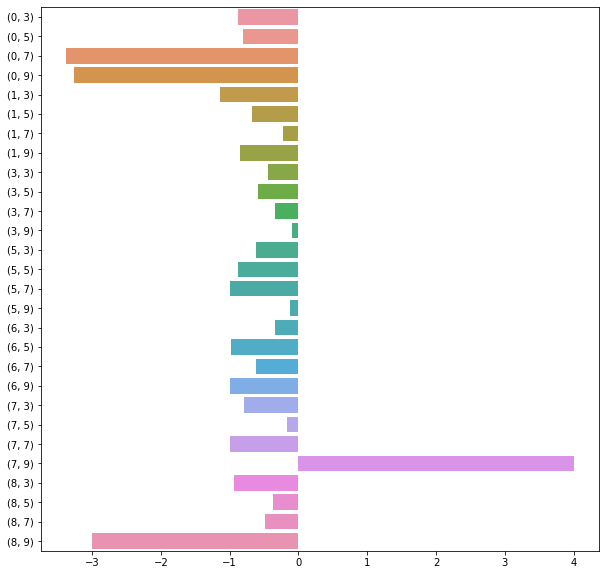

In [18]:
plt.figure(figsize=(10,10))
sns.barplot(x=list(Q_dict['x-x-2-x-1-x-x-x-x'].values()), y=[str(i) for i in list(Q_dict['x-x-2-x-1-x-x-x-x'].keys())], orient='h')
plt.show()

From above plot, we note that agent is trying to taken the action of `(7,9)` from the state of `x-x-2-x-1-x-x-x-x`

## 6. Check the states tracked for Q-values convergence

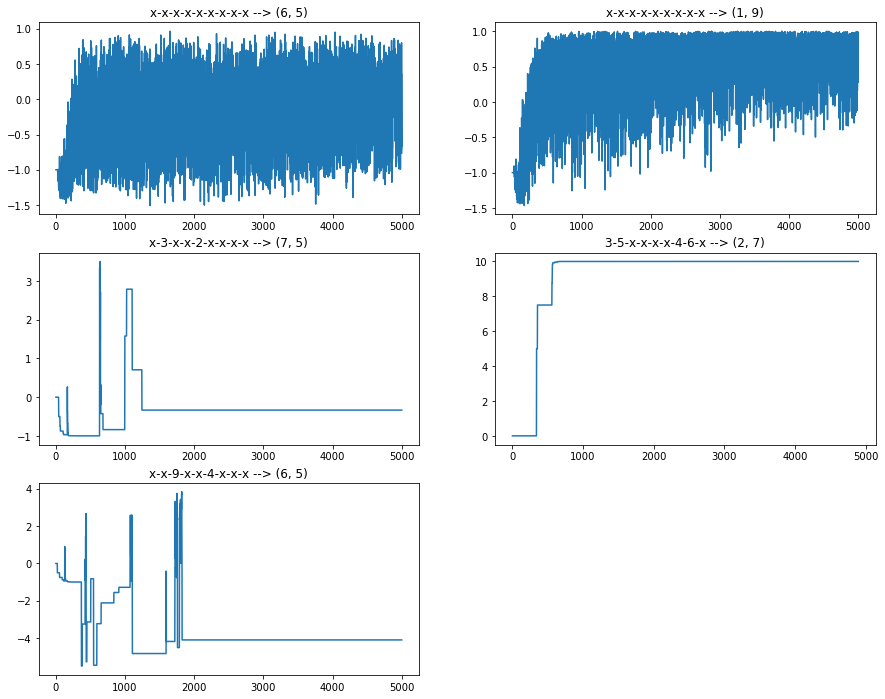

In [28]:
# plotting the graphs for state-action pairs tracked

i=1
plt.figure(figsize=(15, 12))
for state in States_track.keys():
    for action in States_track[state].keys():
        plt.subplot(3,2,i)
        i+=1
        plt.plot(States_track[state][action])
        plt.title(str(state)+' --> '+str(action))
        

## 7. Check the Reward tracked

In [56]:
max(reward_cum_ep)

8

From above, we note that the maximum reward that we would achieve is 8, which is justifiable as agent would have to take atleast two steps before winning any game and those two steps would penalise it by giving -1 reward.

In [58]:
min(reward_cum_ep)

-13

From above, we note that the minimu reward that we would achieve is -13, which also is justifiable.

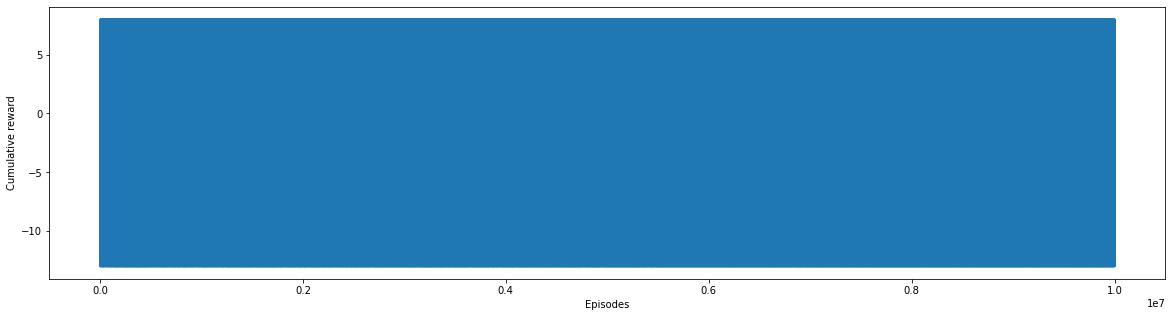

In [60]:
# total reward tracking

plt.figure(figsize=(20,5))
plt.plot(reward_cum_ep)   
plt.xlabel('Episodes')
plt.ylabel('Cumulative reward')
plt.show()

Let's enhance our visibilty by picking only 5000th episode for our plot.

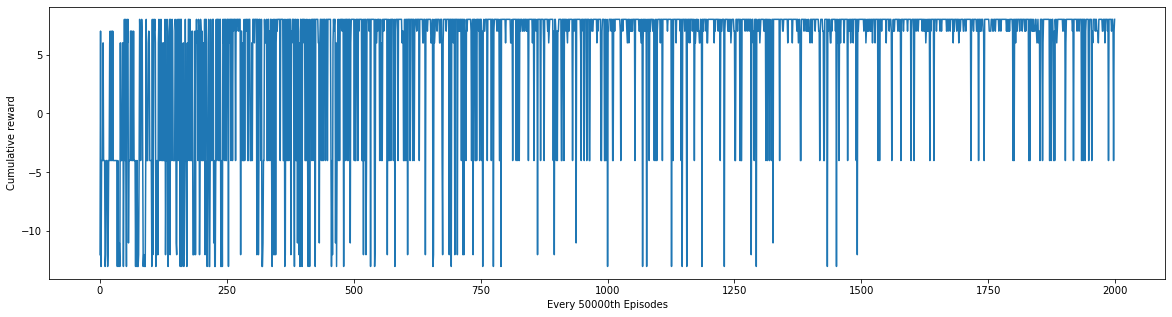

In [46]:
# total reward tracking

plt.figure(figsize=(20,5))
plt.plot(reward_cum_ep[0:-1:5000])   
plt.xlabel('Every 5000th Episodes')
plt.ylabel('Cumulative reward')
plt.show()

From above, we note that the variance in the reward is reducing as the no. of episode run is rising. Let's try the moving average for all the episodes to get the better visualization of cumulative reward per episode.

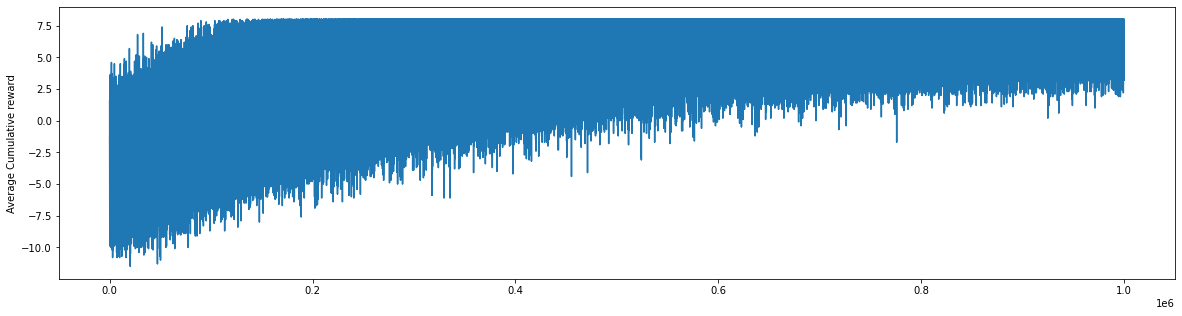

In [61]:
container=0
out_list = []
for i,j in enumerate(reward_cum_ep):
    container+=j
    if i%10==0:
        out_list.append(container/10)
        container=0
        
plt.figure(figsize=(20,5))
plt.plot(out_list)   
plt.ylabel('Average Cumulative reward')
plt.show()

From above, we note a clear trend of reduction in variance in cumulative reward per episode.

## 8. Epsilon - decay check

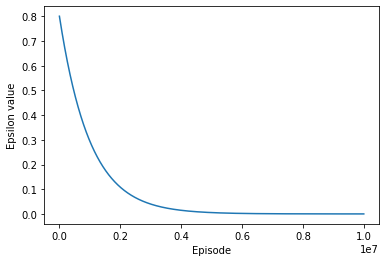

In [35]:
# def epsilon_greedy(state, time):
#     epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
#     z = np.random.random()
        
#     if z > epsilon:
#         action = max(Q_dict[state],key=Q_dict[state].get)   #Exploitation: this gets the action corresponding to max q-value of current state
#     else:
#         action = np.random.choice(valid_actions(state))    #Exploration: randomly choosing and action
    
#     return action

# Let's plot the epsilon to check it's goodness

out_list = []
for ep in range(10000000):
    out_list.append( 0.8*np.power(1.000001,-ep)) 

plt.plot(out_list)
plt.xlabel('Episode')
plt.ylabel('Epsilon value')
plt.show()